In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm

from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter

import warnings
import os
import sys
warnings.filterwarnings("ignore")



In [2]:
plt.style.use('notebook')

In [3]:
#--- iSpec directory -------------------------------------------------------------
# ispec_dir = os.path.dirname(os.path.realpath(__file__)) + "/"
ispec_dir = '/Users/daniel/iSpec/'
sys.path.insert(0, os.path.abspath(ispec_dir))
import ispec

In [4]:

import logging
LOG_LEVEL = "error"
logger = logging.getLogger() # root logger, common for all
logger.setLevel(logging.getLevelName(LOG_LEVEL.upper()))

In [5]:
# plt.style.use('notebook')
spectra_dir = 'data/Spectra/SONG/'

In [6]:
# synth_spec = 'data/Spectra/SOPHIE/SS_AlphaDra_final_4400_4600.norm'
# synth_wav, synth_flux = np.loadtxt(synth_spec, usecols=(0,1)).T
# np.savetxt('synthesis/harps_synth.txt', list(zip(synth_wav / 10, synth_flux, np.ones_like(synth_flux) * 0.01)))

# harps_synth = ispec.read_spectrum('synthesis/harps_synth.txt')

# plt.plot(harps_synth['waveobs'], harps_synth['flux'])

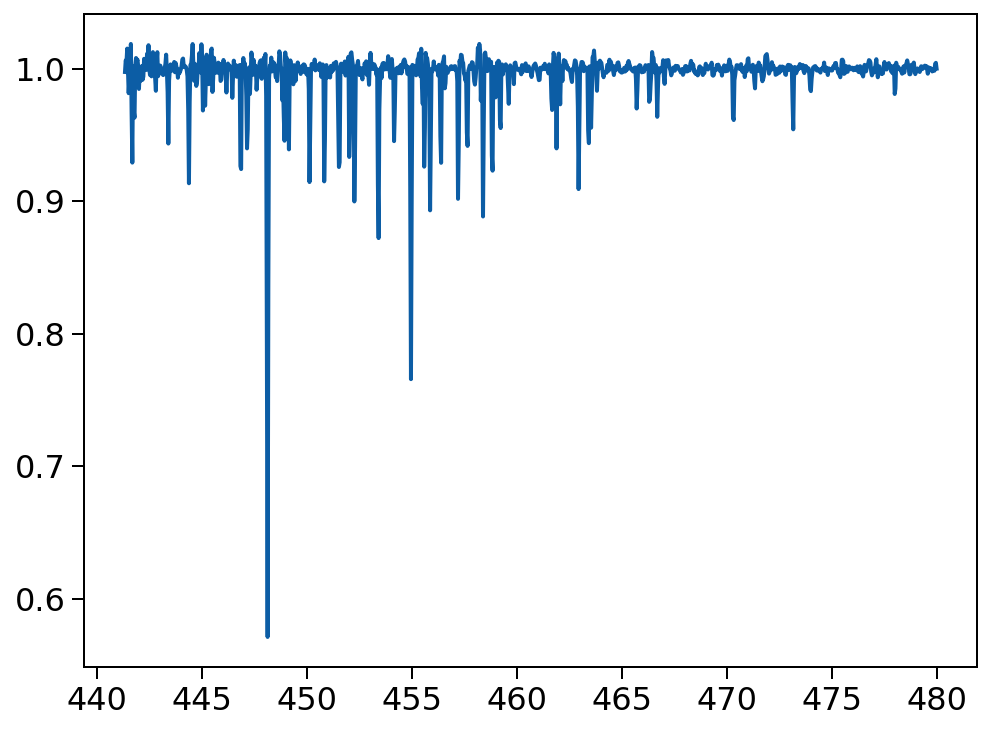

In [7]:
star_spectrum = ispec.read_spectrum(f"primary_spec.txt")

def smooth(x, y, factor=0.05):
    df = x[1] - x[0]
    return gaussian_filter(y, factor / df)

def estimate_background(x, y, log_width=0.05):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

bkg = estimate_background(star_spectrum['waveobs'], star_spectrum['flux'], log_width=0.00015)
# cont = fit_continuum(star_spectrum['waveobs'], np.log(star_spectrum['waveobs']), ivars=np.ones_like(star_spectrum['waveobs']))
# star_spectrum['flux'] /= bkg
# plt.plot(star_spectrum['waveobs'], star_spectrum['flux'] / bkg)

# star_spectrum['flux'] = smooth(star_spectrum['waveobs'], star_spectrum['flux'])
# plt.plot(star_spectrum['waveobs'], star_spectrum['flux'])
# plt.plot(star_spectrum['waveobs'], bkg)


star_spectrum['flux'] /= bkg

m = star_spectrum['waveobs'] < 480
star_spectrum_cut = ispec.create_spectrum_structure(star_spectrum['waveobs'][m])
star_spectrum_cut['flux'], star_spectrum_cut['err'] = star_spectrum['flux'][m], star_spectrum['err'][m]

plt.plot(star_spectrum_cut['waveobs'], star_spectrum_cut['flux'])

In [8]:
star_spectrum = star_spectrum_cut

In [9]:
# plt.plot(harps_synth['waveobs'], harps_synth['flux'])
# plt.plot(star_spectrum['waveobs'], star_spectrum['flux'])

# # plt.xlim(440, 460)

In [10]:
#--- Synthesizing spectrum -----------------------------------------------------
# Parameters
teff = 9975
logg = 3.63
MH = -0.56
alpha = ispec.determine_abundance_enchancements(MH)
microturbulence_vel = 0.#ispec.estimate_vmic(teff, logg, MH) # 1.07
macroturbulence = 0.#ispec.estimate_vmac(teff, logg, MH) # 4.21
vsini = 26. # Sun
limb_darkening_coeff = 0.6
resolution = 300000
wave_step = 0.001

# Wavelengths to synthesis
wave_base = star_spectrum['waveobs'].min()
wave_top = star_spectrum['waveobs'].max()

# Load up all the models
model = ispec_dir + "/input/atmospheres/ATLAS9.Castelli/"
atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.300_1100nm/atomic_lines.tsv"
isotope_file = ispec_dir + "/input/isotopes/SPECTRUM.lst"

# Load chemical information and linelist
atomic_linelist = ispec.read_atomic_linelist(atomic_linelist_file, wave_base=wave_base, wave_top=wave_top)
atomic_linelist = atomic_linelist[atomic_linelist['theoretical_depth'] >= 0.01] # Select lines that have some minimal contribution in the sun

isotopes = ispec.read_isotope_data(isotope_file)
solar_abundances_file = ispec_dir + "/input/abundances/Grevesse.1998/stdatom.dat"

# Load model atmospheres
modeled_layers_pack = ispec.load_modeled_layers_pack(model)
# Load SPECTRUM abundances
solar_abundances = ispec.read_solar_abundances(solar_abundances_file)


In [11]:
def synthesise_spectrum(wav, teff, logg, MH, microturbulence, macroturbulence, vsini,
                       code='turbospectrum', fixed_abundances=None, regions=None):
    if not ispec.valid_atmosphere_target(modeled_layers_pack, {'teff':teff, 'logg':logg, 'MH':MH, 'alpha':alpha}):
        msg = "The specified effective temperature, gravity (log g) and metallicity [M/H] \
                fall out of theatmospheric models."
        print(msg)
        return np.nan()

    # Prepare atmosphere model
    atmosphere_layers = ispec.interpolate_atmosphere_layers(modeled_layers_pack, {'teff':teff, 'logg':logg, 'MH':MH, 'alpha':alpha}, code=code)

    # Synthesis
    synth_spectrum = ispec.create_spectrum_structure(wav)
    synth_spectrum['flux'] = ispec.generate_spectrum(wav, \
            atmosphere_layers, teff, logg, MH, alpha, atomic_linelist, isotopes, solar_abundances, \
            fixed_abundances, microturbulence_vel = microturbulence_vel, \
            macroturbulence=macroturbulence, vsini=vsini, limb_darkening_coeff=limb_darkening_coeff, \
            R=resolution, regions=regions, verbose=1,
            code=code)
    return synth_spectrum

def lnlike(params, x, y, yerr):
    teff, logg, MH, vsini = params
    print(params)
    synth_spec = synthesise_spectrum(x, teff, logg, MH, 0, 0, vsini)
    return -0.5 * np.sum((y[1:-3] - synth_spec['flux'][1:-3]) ** 2)

nll = lambda *args: -lnlike(*args)

In [13]:
x0 = [teff, logg, MH, 26]
nll(x0, star_spectrum['waveobs'], star_spectrum['flux'], star_spectrum['err'])

[9975, 3.63, -0.56, 26]


0.3865859804956263

In [44]:
from scipy.optimize import minimize

soln = minimize(nll, x0, args=(star_spectrum['waveobs'], star_spectrum['flux'], star_spectrum['err']))

[ 9.975e+03  3.630e+00 -5.600e-01  0.000e+00  0.000e+00  2.600e+01]
[ 9.975e+03  3.630e+00 -5.600e-01  0.000e+00  0.000e+00  2.600e+01]
[ 9.97500000e+03  3.63000001e+00 -5.60000000e-01  0.00000000e+00
  0.00000000e+00  2.60000000e+01]
[ 9.97500000e+03  3.63000000e+00 -5.59999985e-01  0.00000000e+00
  0.00000000e+00  2.60000000e+01]
[ 9.97500000e+03  3.63000000e+00 -5.60000000e-01  1.49011612e-08
  0.00000000e+00  2.60000000e+01]
[ 9.97500000e+03  3.63000000e+00 -5.60000000e-01  0.00000000e+00
  1.49011612e-08  2.60000000e+01]
[ 9.975e+03  3.630e+00 -5.600e-01  0.000e+00  0.000e+00  2.600e+01]
[9.97500000e+03 2.84798763e+00 7.90891212e-02 0.00000000e+00
 0.00000000e+00 2.60110342e+01]
[9.97500000e+03 2.84798763e+00 7.90891212e-02 0.00000000e+00
 0.00000000e+00 2.60110342e+01]
[9.97500000e+03 2.84798765e+00 7.90891212e-02 0.00000000e+00
 0.00000000e+00 2.60110342e+01]
[9.97500000e+03 2.84798763e+00 7.90891361e-02 0.00000000e+00
 0.00000000e+00 2.60110342e+01]
[9.97500000e+03 2.84798763e+

KeyboardInterrupt: 

In [32]:
# %%timeit
codes = ['turbospectrum', 'moog', 'sme']
wav = star_spectrum['waveobs']

synth = []
for code in codes:
    synth.append(synthesise_spectrum(wav, teff, logg, MH, 0, 0, 26, code=code))

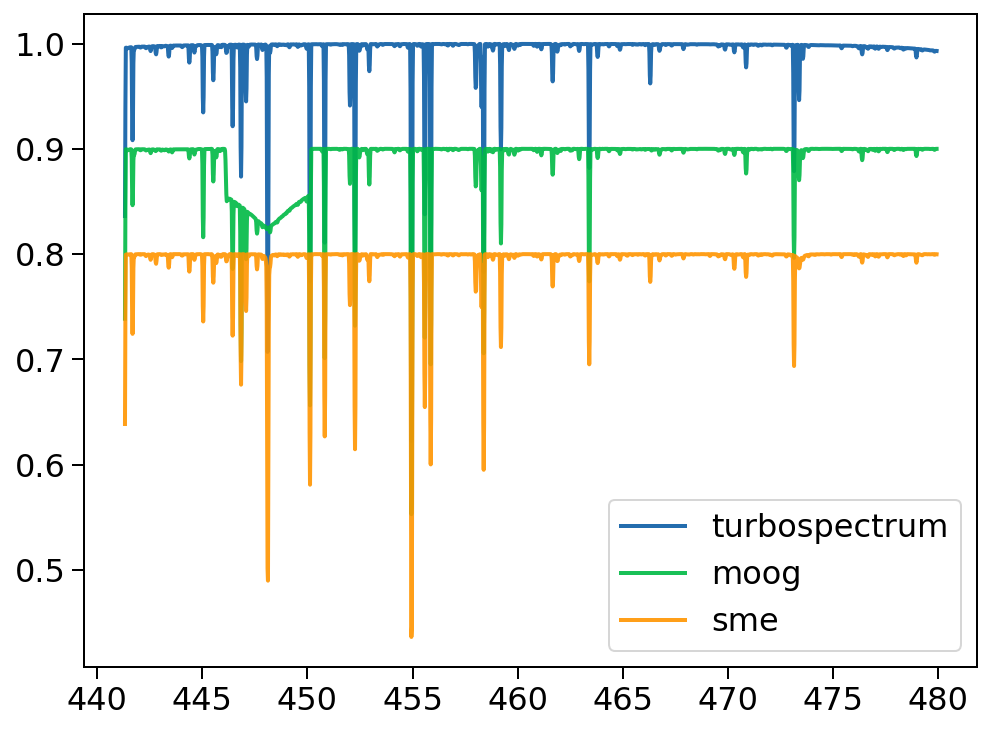

In [34]:
for i in range(len(synth)):
    plt.plot(synth[i]['waveobs'][1:-3], synth[i]['flux'][1:-3] - i*0.1, alpha=0.9, label=codes[i])
    
plt.legend()

# Turbospectrum it is!

In [199]:


# Selected model amtosphere, linelist and solar abundances
#model = ispec_dir + "/input/atmospheres/MARCS/"
# model = ispec_dir + "/input/atmospheres/MARCS.GES/"
#model = ispec_dir + "/input/atmospheres/MARCS.APOGEE/"
#model = ispec_dir + "/input/atmospheres/ATLAS9.APOGEE/"
model = ispec_dir + "/input/atmospheres/ATLAS9.Castelli/"
# model = ispec_dir + "/input/atmospheres/ATLAS9.Kurucz/"
# model = ispec_dir + "/input/abundances/ATLAS9.Kurucz/"
#model = ispec_dir + "/input/atmospheres/ATLAS9.Kirby/"

atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.300_1100nm/atomic_lines.tsv"
#atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.1100_2400nm/atomic_lines.tsv"
# atomic_linelist_file = ispec_dir + "/input/linelists/transitions/GESv6_atom_hfs_iso.420_920nm/atomic_lines.tsv"
#atomic_linelist_file = ispec_dir + "/input/linelists/transitions/GESv6_atom_nohfs_noiso.420_920nm/atomic_lines.tsv"

isotope_file = ispec_dir + "/input/isotopes/SPECTRUM.lst"

# Load chemical information and linelist
atomic_linelist = ispec.read_atomic_linelist(atomic_linelist_file, wave_base=wave_base, wave_top=wave_top)
atomic_linelist = atomic_linelist[atomic_linelist['theoretical_depth'] >= 0.01] # Select lines that have some minimal contribution in the sun

isotopes = ispec.read_isotope_data(isotope_file)

if "ATLAS" in model:
    solar_abundances_file = ispec_dir + "/input/abundances/Grevesse.1998/stdatom.dat"
else:
    # MARCS
    solar_abundances_file = ispec_dir + "/input/abundances/Grevesse.2007/stdatom.dat"
#solar_abundances_file = ispec_dir + "/input/abundances/Asplund.2005/stdatom.dat"
# solar_abundances_file = ispec_dir + "/input/abundances/Asplund.2009/stdatom.dat"
#solar_abundances_file = ispec_dir + "/input/abundances/Anders.1989/stdatom.dat"

# Load model atmospheres
modeled_layers_pack = ispec.load_modeled_layers_pack(model)
# Load SPECTRUM abundances
solar_abundances = ispec.read_solar_abundances(solar_abundances_file)

## Custom fixed abundances
#fixed_abundances = ispec.create_free_abundances_structure(["C", "N", "O"], chemical_elements, solar_abundances)
#fixed_abundances['Abund'] = [-3.49, -3.71, -3.54] # Abundances in SPECTRUM scale (i.e., x - 12.0 - 0.036) and in the same order ["C", "N", "O"]
## No fixed abundances
fixed_abundances = None

# Validate parameters
if not ispec.valid_atmosphere_target(modeled_layers_pack, {'teff':teff, 'logg':logg, 'MH':MH, 'alpha':alpha}):
    msg = "The specified effective temperature, gravity (log g) and metallicity [M/H] \
            fall out of theatmospheric models."
    print(msg)

# Prepare atmosphere model
atmosphere_layers = ispec.interpolate_atmosphere_layers(modeled_layers_pack, {'teff':teff, 'logg':logg, 'MH':MH, 'alpha':alpha}, code=code)

# Synthesis
synth_spectrum = ispec.create_spectrum_structure(star_spectrum['waveobs'])
synth_spectrum['flux'] = ispec.generate_spectrum(synth_spectrum['waveobs'], \
        atmosphere_layers, teff, logg, MH, alpha, atomic_linelist, isotopes, solar_abundances, \
        fixed_abundances, microturbulence_vel = microturbulence_vel, \
        macroturbulence=macroturbulence, vsini=vsini, limb_darkening_coeff=limb_darkening_coeff, \
        R=resolution, regions=regions, verbose=1,
        code=code)
##--- Save spectrum ------------------------------------------------------------
# logging.info("Saving spectrum...")
# synth_filename = "example_synth_%s.fits" % (code)
# ispec.write_spectrum(synth_spectrum, synth_filename)

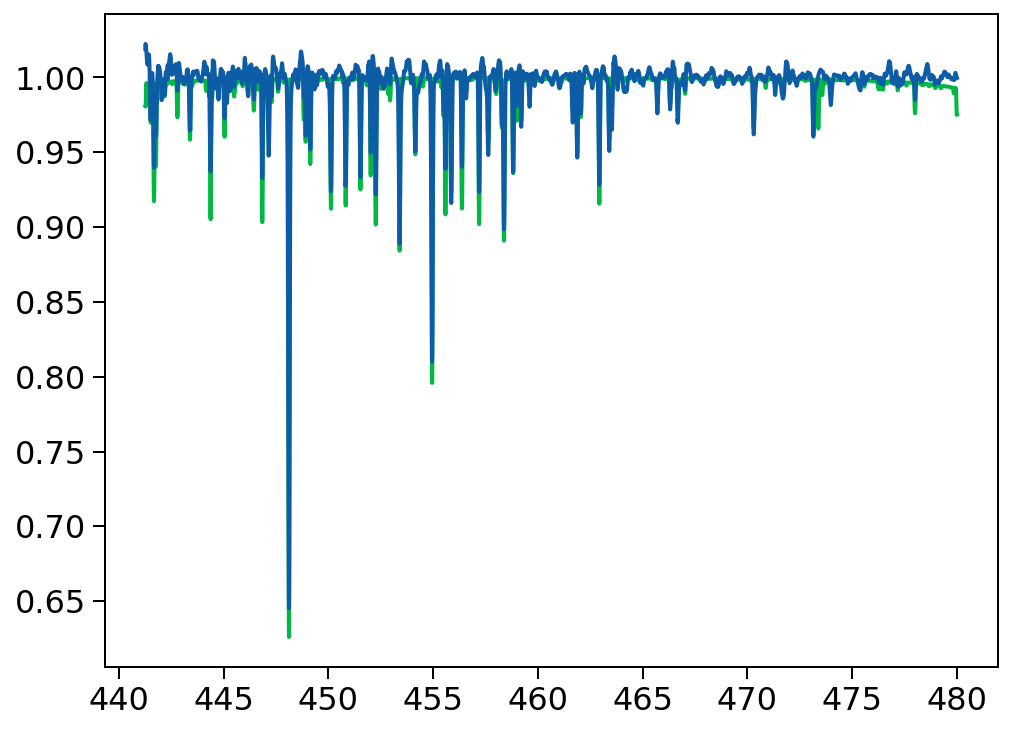

In [202]:
plt.plot(synth_spectrum['waveobs'][1:-3], synth_spectrum['flux'][1:-3], c='C1', alpha=1)
plt.plot(star_spectrum['waveobs'], star_spectrum['flux'],alpha=1)

# plt.xlim(447, 450)

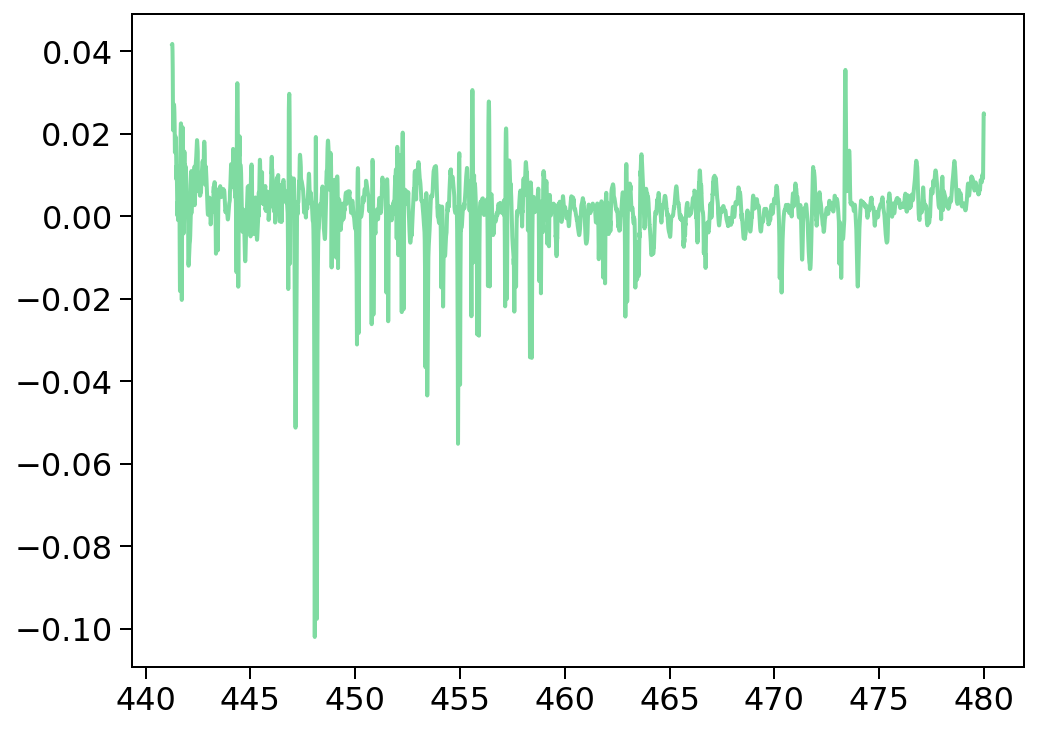

In [201]:
plt.plot(synth_spectrum['waveobs'][1:-3], star_spectrum['flux'][1:-3] - synth_spectrum['flux'][1:-3], c='C1', alpha=0.5)

In [87]:
len(star_spectrum['flux'])

6140